In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hourly-energy-consumption/est_hourly.paruqet
/kaggle/input/hourly-energy-consumption/DOM_hourly.csv
/kaggle/input/hourly-energy-consumption/EKPC_hourly.csv
/kaggle/input/hourly-energy-consumption/DUQ_hourly.csv
/kaggle/input/hourly-energy-consumption/DAYTON_hourly.csv
/kaggle/input/hourly-energy-consumption/PJME_hourly.csv
/kaggle/input/hourly-energy-consumption/PJM_Load_hourly.csv
/kaggle/input/hourly-energy-consumption/NI_hourly.csv
/kaggle/input/hourly-energy-consumption/FE_hourly.csv
/kaggle/input/hourly-energy-consumption/COMED_hourly.csv
/kaggle/input/hourly-energy-consumption/AEP_hourly.csv
/kaggle/input/hourly-energy-consumption/pjm_hourly_est.csv
/kaggle/input/hourly-energy-consumption/DEOK_hourly.csv
/kaggle/input/hourly-energy-consumption/PJMW_hourly.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense,BatchNormalization,LSTM,Bidirectional
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.utils import Sequence
import tensorflow as tf
from sklearn.metrics import r2_score
from tensorflow.keras.metrics import RootMeanSquaredError,MeanSquaredError
import sklearn.preprocessing
import datetime

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Data Observation

In [3]:
data = pd.read_csv("/kaggle/input/hourly-energy-consumption/PJME_hourly.csv")
data.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
data_obs=data.copy()
data_obs=data_obs.set_index("Datetime")
data_obs.index=pd.to_datetime(data_obs.index)
PJME_MW_decompose=seasonal_decompose(data_obs["PJME_MW"],model="additive",period=1)

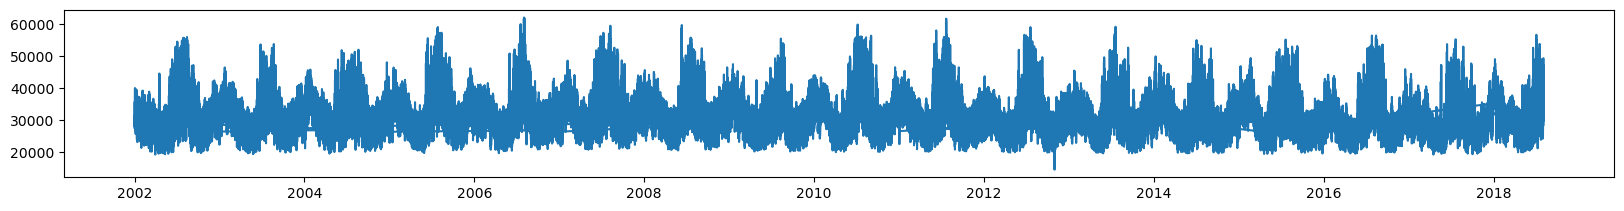

In [5]:
plt.figure(figsize=(20,10))
plt.subplot(411)
plt.plot(PJME_MW_decompose.trend)

<Axes: xlabel='month', ylabel='PJME_MW'>

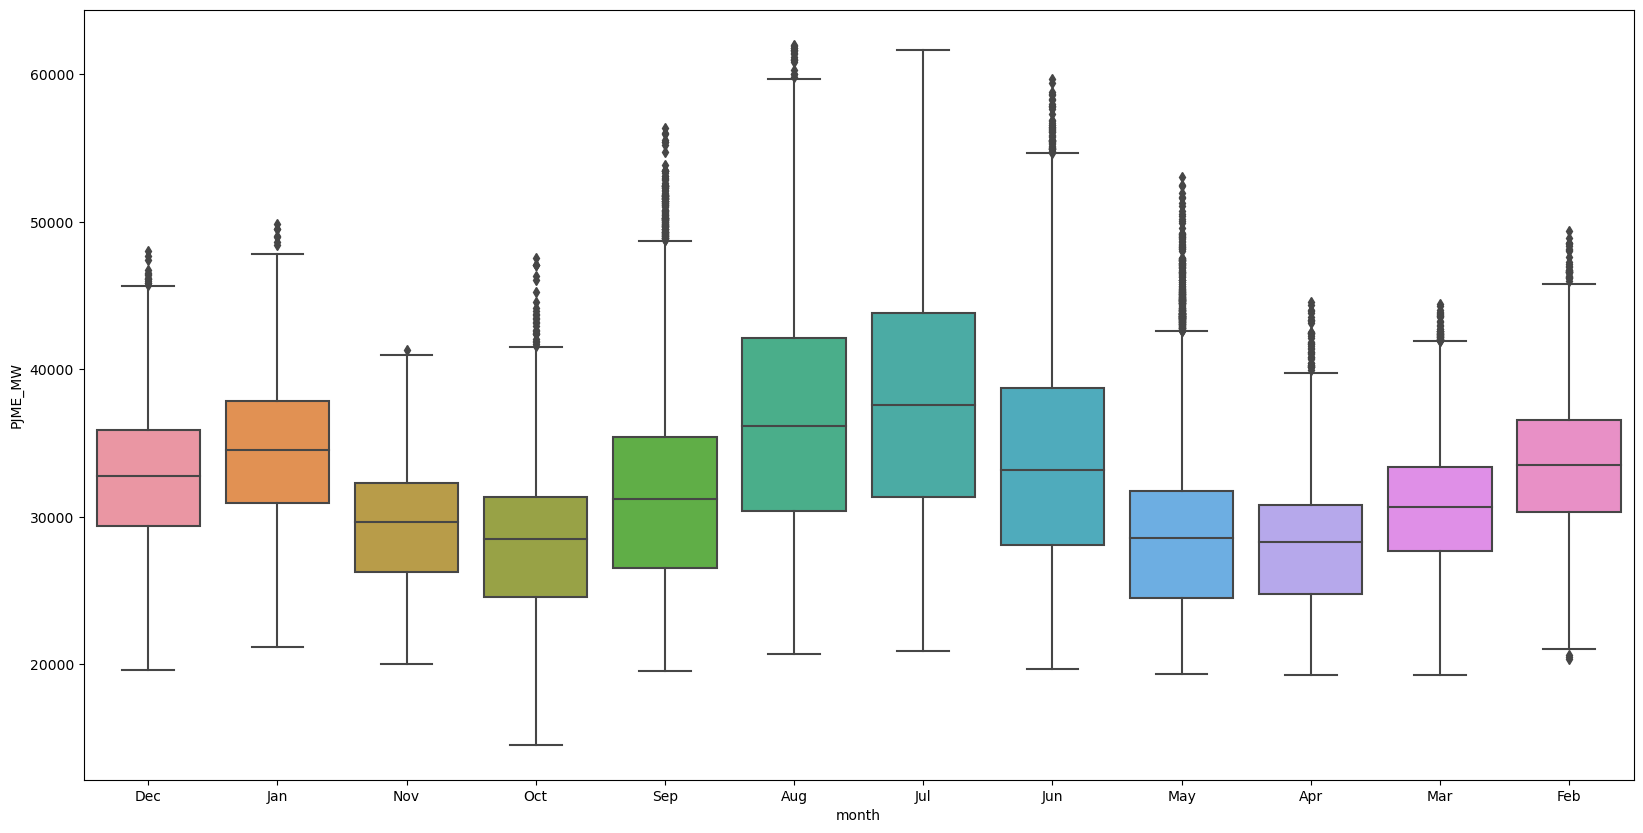

In [6]:
data_obs["year"]=[d.year for d in data_obs.index]
data_obs["month"]=[d.strftime('%b') for d in data_obs.index]
plt.figure(figsize=(20,10))
sns.boxplot(x=data_obs["month"],y=data_obs["PJME_MW"])

<Axes: xlabel='year', ylabel='PJME_MW'>

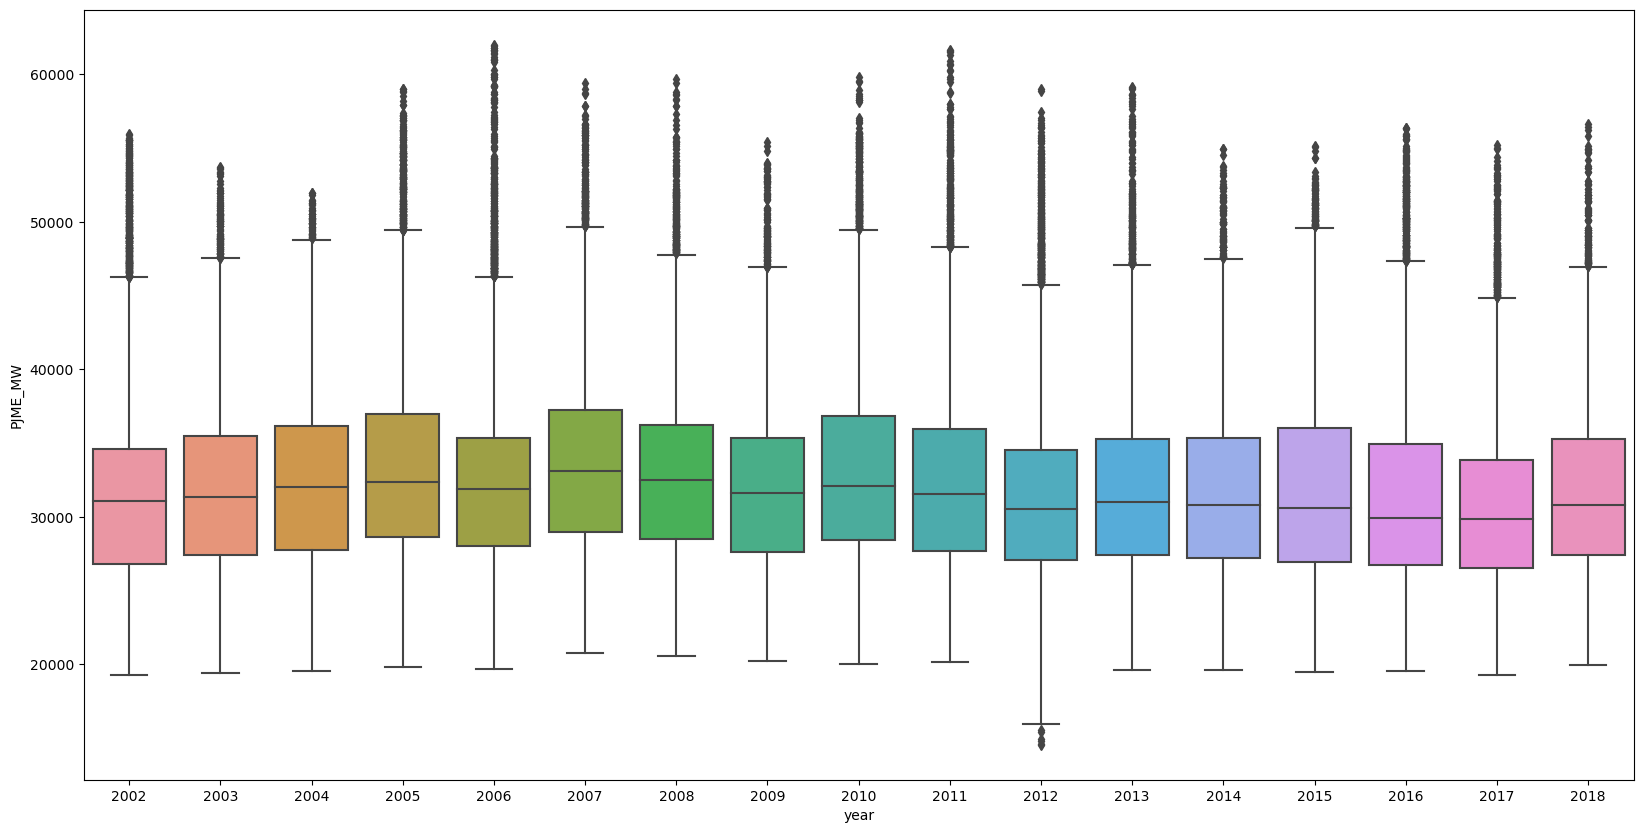

In [7]:
plt.figure(figsize=(20,10))
sns.boxplot(x=data_obs["year"],y=data_obs["PJME_MW"],)

# Normalization and removing outliers

The reason to normalize data is if we run code on unnormalized data, XGB may show not so bad result, but when running LSTM we well face up with huge MSE values. It can be fixed with regularization and other methods, but the simpliest way is to normalize data first

In [8]:
measure=data.describe()
measure

,PJME_MW
count,145366.000000
mean,32080.222831
std,6464.012166
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


In [9]:
#outliers detection using standart deviation and mean
u=2
aElevation=0
bElevation=0

aElevation=measure["PJME_MW"][1] - u*measure["PJME_MW"][2]
bElevation=measure["PJME_MW"][1] + u*measure["PJME_MW"][2]

print('low bound:',aElevation,'high bound:',bElevation)

low bound: 19152.198497822686 high bound: 45008.24716347363


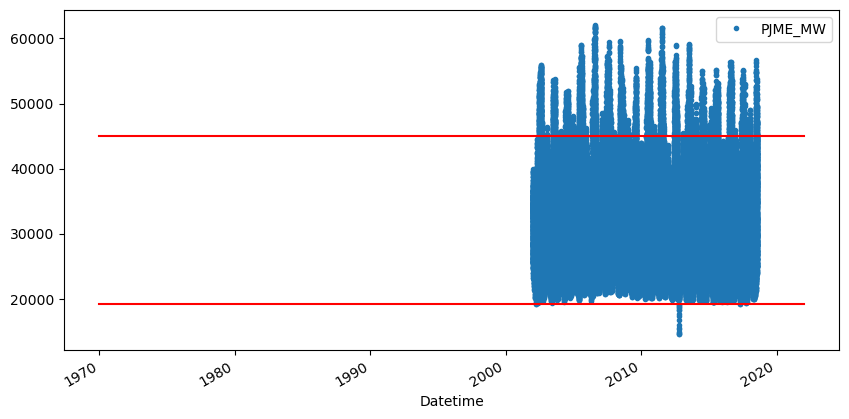

In [10]:
df=data.copy()
df=df.set_index("Datetime")
df.index=pd.to_datetime(df.index)
df.plot(style=".",figsize=(10,5))
plt.plot([0,19000],[aElevation,aElevation],color='red')
plt.plot([0,19000],[bElevation,bElevation],color='red')
plt.show()

<Axes: >

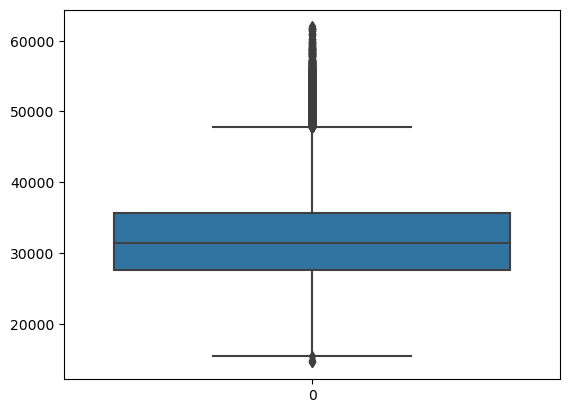

In [11]:
sns.boxplot(data.PJME_MW)

<Axes: xlabel='Datetime'>

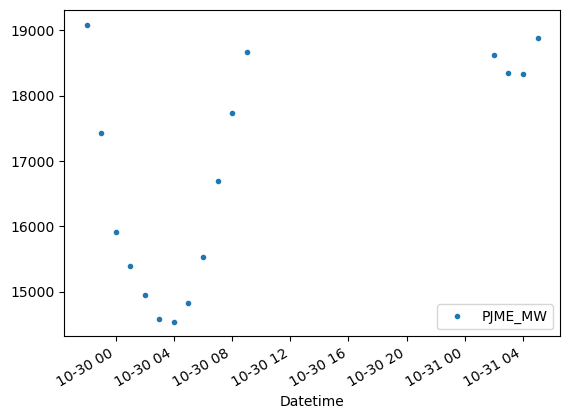

In [12]:
df.query("PJME_MW<19_152").plot(style='.')

In [13]:
high_bound=data.query("PJME_MW>45_008").value_counts().sum()
low_bound=data.query("PJME_MW<19_152").value_counts().sum()
print("outliers<19_152:",(low_bound*100)/145366,"%",",outliers>45008:",(high_bound*100)/145366,"%")

outliers<19_152: 0.011006700328825173 % ,outliers>45008: 4.289861453159611 %


<Axes: >

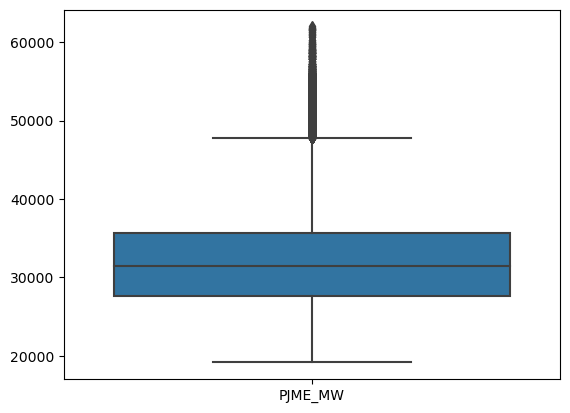

In [14]:
data=data.query("PJME_MW>19_152").copy()
sns.boxplot(data)

In [15]:
def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['PJME_MW']=scaler.fit_transform(df['PJME_MW'].values.reshape(-1,1))
    return df

df_norm = normalize_data(data)
df_norm

,Datetime,PJME_MW
0,2002-12-31 01:00:00,0.171349
1,2002-12-31 02:00:00,0.139824
2,2002-12-31 03:00:00,0.126453
3,2002-12-31 04:00:00,0.122229
4,2002-12-31 05:00:00,0.133126
...,...,...
145361,2018-01-01 20:00:00,0.586386
145362,2018-01-01 21:00:00,0.573949
145363,2018-01-01 22:00:00,0.542470
145364,2018-01-01 23:00:00,0.490246


In [16]:

data_forecasting_xgb=df_norm.copy()
data_forecasting_lstm=df_norm.copy()
#data_forecasting_xgb=data.copy()


# Forecasting with xgb

In [17]:
data_forecasting_xgb=data_forecasting_xgb.set_index("Datetime")
data_forecasting_xgb.index=pd.to_datetime(data_forecasting_xgb.index)


In [18]:
data_forecasting_xgb

,PJME_MW
Datetime,
2002-12-31 01:00:00,0.171349
2002-12-31 02:00:00,0.139824
2002-12-31 03:00:00,0.126453
2002-12-31 04:00:00,0.122229
2002-12-31 05:00:00,0.133126
...,...
2018-01-01 20:00:00,0.586386
2018-01-01 21:00:00,0.573949
2018-01-01 22:00:00,0.542470


In [19]:
from sklearn.model_selection import TimeSeriesSplit
tss=TimeSeriesSplit(n_splits=5,test_size=24*365,gap=24)#1 year
data_forecasting_xgb=data_forecasting_xgb.sort_index()


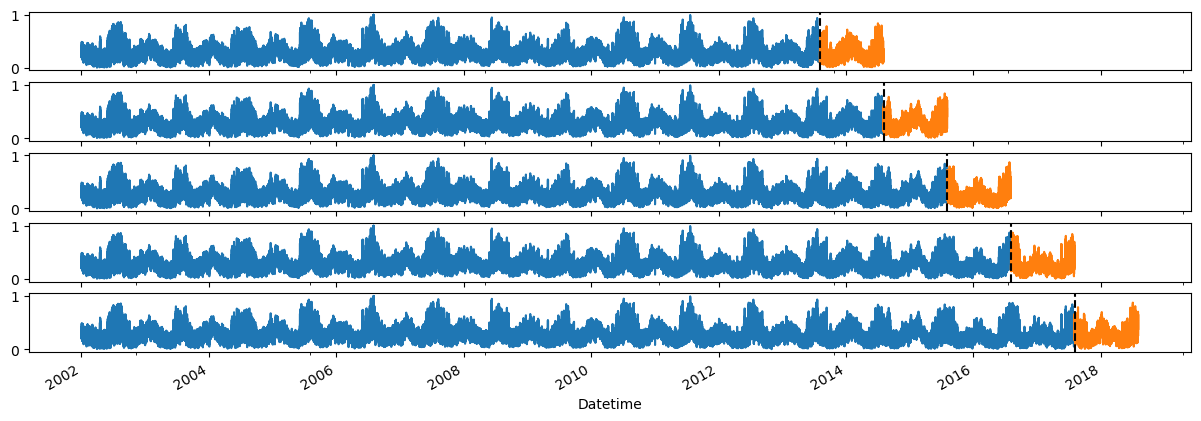

In [20]:
fold=0
fig,axs=plt.subplots(5,1,figsize=(15,5),sharex=True)
for train_idx,val_idx in tss.split(data_forecasting_xgb):
  train=data_forecasting_xgb.iloc[train_idx]
  train['PJME_MW'].plot(ax=axs[fold],label='training set')
  test=data_forecasting_xgb.iloc[val_idx]
  test['PJME_MW'].plot(ax=axs[fold],label='test set')
  axs[fold].axvline(test.index.min(), color='black', ls='--')
  fold+=1
plt.show()

In [21]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

data_forecasting_xgb = create_features(data_forecasting_xgb)

**Create Lags for 4 years**

In [22]:
tmap=df.PJME_MW.to_dict()
def create_lags(df):
  df['lag_1y']=(df.index-pd.Timedelta('364 days')).map(tmap)
  df['lag_2y']=(df.index-pd.Timedelta('728 days')).map(tmap)
  df['lag_3y']=(df.index-pd.Timedelta('1092 days')).map(tmap)
  df['lag_4y']=(df.index-pd.Timedelta('1456 days')).map(tmap)
  return df
data_forecasting_xgb=create_lags(data_forecasting_xgb)

In [23]:
data_forecasting_xgb

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag_1y,lag_2y,lag_3y,lag_4y
Datetime,,,,,,,,,,,,,
2002-01-01 01:00:00,0.262239,1,1,1,1,2002,1,1,1,NaN,NaN,NaN,NaN
2002-01-01 02:00:00,0.235917,2,1,1,1,2002,1,1,1,NaN,NaN,NaN,NaN
2002-01-01 03:00:00,0.214729,3,1,1,1,2002,1,1,1,NaN,NaN,NaN,NaN
2002-01-01 04:00:00,0.204042,4,1,1,1,2002,1,1,1,NaN,NaN,NaN,NaN
2002-01-01 05:00:00,0.207729,5,1,1,1,2002,1,1,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,0.581089,20,3,3,8,2018,214,2,31,42256.0,41485.0,38804.0,37889.0
2018-08-02 21:00:00,0.562398,21,3,3,8,2018,214,2,31,41210.0,40249.0,38748.0,37419.0
2018-08-02 22:00:00,0.522635,22,3,3,8,2018,214,2,31,39525.0,38698.0,37330.0,35897.0


In [24]:

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(data_forecasting_xgb):
    train = data_forecasting_xgb.iloc[train_idx]
    test = data_forecasting_xgb.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag_1y','lag_2y','lag_3y','lag_4y']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[18:52:44] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.24147	validation_1-rmse:0.25000
[100]	validation_0-rmse:0.12284	validation_1-rmse:0.12517
[200]	validation_0-rmse:0.09219	validation_1-rmse:0.09444
[300]	validation_0-rmse:0.08257	validation_1-rmse:0.08877
[400]	validation_0-rmse:0.07855	validation_1-rmse:0.08823
[427]	validation_0-rmse:0.07790	validation_1-rmse:0.08835
[18:53:02] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.24215	validation_1-rmse:0.24868
[100]	validation_0-rmse:0.12322	validation_1-rmse:0.12231
[200]	validation_0-rmse:0.09261	validation_1-rmse:0.08985
[300]	validation_0-rmse:0.08362	validation_1-rmse:0.08314
[400]	validation_0-rmse:0.07970	validation_1-rmse:0.08157
[500]	validation_0-rmse:0.07773	validation_1-rmse:0.08119
[600]	validation_0-rmse:0.07656	validation_1-rmse:0.08082
[700]	valida

In [25]:
x=data_forecasting_xgb[FEATURES]
y=data_forecasting_xgb['PJME_MW']
reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(x, y,
        eval_set=[(x, y)],
        verbose=100)

[18:55:04] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.24706
[100]	validation_0-rmse:0.12486
[200]	validation_0-rmse:0.09349
[300]	validation_0-rmse:0.08531
[400]	validation_0-rmse:0.08184
[499]	validation_0-rmse:0.08009


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

# Feature Predicting 

In [26]:
# create one-year hourly datarange 
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
#stick future date on data we already have
future_df['isFuture'] = True
data_forecasting_xgb['isFuture'] = False
df_and_future = pd.concat([data_forecasting_xgb, future_df])
df_and_future = create_features(df_and_future)
df_and_future = create_lags(df_and_future)
#creates dataframe with only future data
future_w_features = df_and_future.query('isFuture').copy()

#predict is PJME_MW
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])
future_w_features

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag_1y,lag_2y,lag_3y,lag_4y,isFuture,pred
2018-08-03 00:00:00,NaN,0,4,3,8,2018,215,3,31,33539.0,32094.0,31695.0,29716.0,True,0.270139
2018-08-03 01:00:00,NaN,1,4,3,8,2018,215,3,31,30781.0,29503.0,29128.0,27084.0,True,0.219986
2018-08-03 02:00:00,NaN,2,4,3,8,2018,215,3,31,29015.0,27712.0,27373.0,25333.0,True,0.207329
2018-08-03 03:00:00,NaN,3,4,3,8,2018,215,3,31,27884.0,26535.0,26233.0,24246.0,True,0.190166
2018-08-03 04:00:00,NaN,4,4,3,8,2018,215,3,31,27223.0,25870.0,25643.0,23682.0,True,0.183513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,31,31,46912.0,39352.0,40243.0,43174.0,True,0.550263
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,31,31,45985.0,38699.0,39183.0,41826.0,True,0.533016
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,31,31,44094.0,37346.0,37759.0,39983.0,True,0.517825
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,31,31,40666.0,34555.0,34641.0,36488.0,True,0.454849


In [27]:
# create one-year hourly datarange 
future_2y = pd.date_range('2018-08-03','2020-08-01', freq='1h')
future_df_2y = pd.DataFrame(index=future_2y)
#stick future date on data we already have
future_df_2y['isFuture'] = True
data_forecasting_xgb['isFuture'] = False
df_and_future_2y = pd.concat([data_forecasting_xgb, future_df_2y])
df_and_future_2y = create_features(df_and_future_2y)
df_and_future_2y = create_lags(df_and_future_2y)
#creates dataframe with only future data
future_w_features_2y = df_and_future_2y.query('isFuture').copy()

#predict is PJME_MW
future_w_features_2y['pred'] = reg.predict(future_w_features_2y[FEATURES])
future_w_features_2y

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag_1y,lag_2y,lag_3y,lag_4y,isFuture,pred
2018-08-03 00:00:00,NaN,0,4,3,8,2018,215,3,31,33539.0,32094.0,31695.0,29716.0,True,0.270139
2018-08-03 01:00:00,NaN,1,4,3,8,2018,215,3,31,30781.0,29503.0,29128.0,27084.0,True,0.219986
2018-08-03 02:00:00,NaN,2,4,3,8,2018,215,3,31,29015.0,27712.0,27373.0,25333.0,True,0.207329
2018-08-03 03:00:00,NaN,3,4,3,8,2018,215,3,31,27884.0,26535.0,26233.0,24246.0,True,0.190166
2018-08-03 04:00:00,NaN,4,4,3,8,2018,215,3,31,27223.0,25870.0,25643.0,23682.0,True,0.183513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-31 20:00:00,NaN,20,4,3,7,2020,213,31,31,NaN,NaN,43606.0,40513.0,True,0.456202
2020-07-31 21:00:00,NaN,21,4,3,7,2020,213,31,31,NaN,NaN,41863.0,39840.0,True,0.454427
2020-07-31 22:00:00,NaN,22,4,3,7,2020,213,31,31,NaN,NaN,40005.0,38664.0,True,0.449537
2020-07-31 23:00:00,NaN,23,4,3,7,2020,213,31,31,NaN,NaN,37174.0,36125.0,True,0.441464


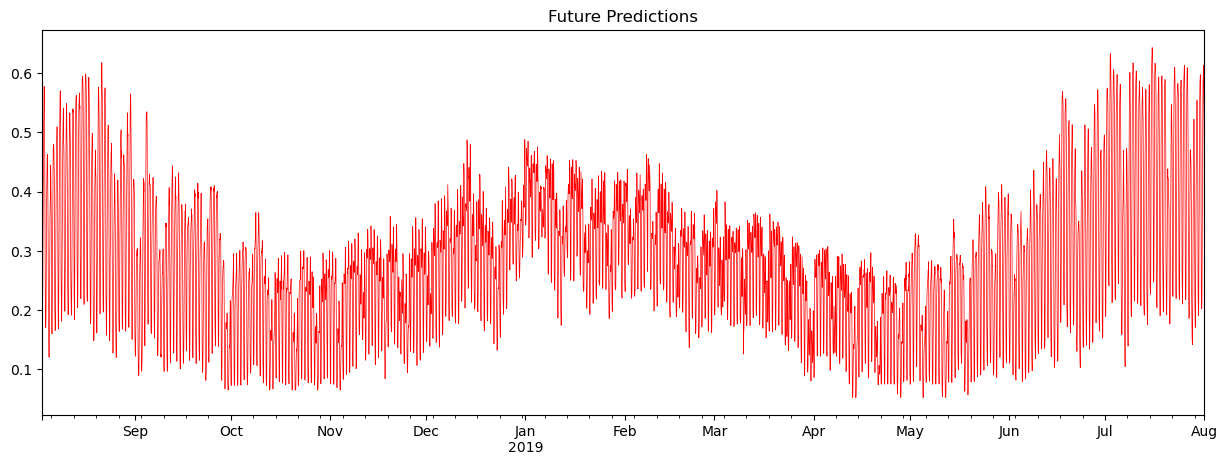

In [28]:
future_w_features['pred'].plot(figsize=(15, 5),
                               color="Red",
                               ms=0.5,
                               lw=0.5,
                               title='Future Predictions')
plt.show()

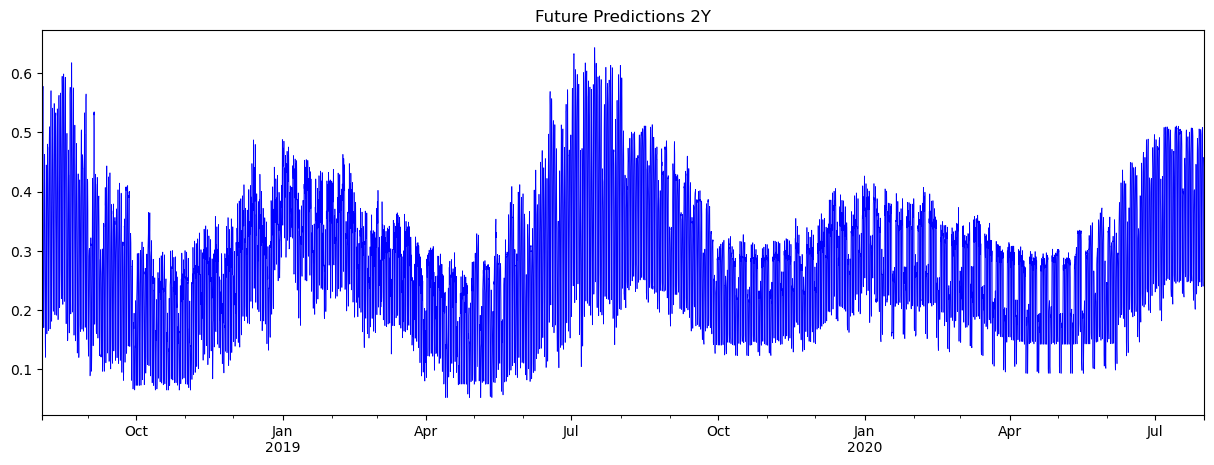

In [29]:
future_w_features_2y['pred'].plot(figsize=(15, 5),
                               color="Blue",
                               ms=0.5,
                               lw=0.5,
                               title='Future Predictions 2Y')
plt.show()

From start to Aug on *Future Predictions 2Y* graph repeats *Future Predictions*, but from Jan 2020 graph repeats itself respectfully to the trand

In [30]:
reg.save_model('forecasting.json')

# Forecasting using LSTM

In this section I will train 2 LSTM model with different data - preparing approaches

1. Preparing test and train set using "standart forecasting approach".
In this approach I divide data by some date: training set contains all data before this date, test set - all data after this date

In [31]:
#create copy from normalizing dataset
data_forecasting_standart_lstm=data_forecasting_lstm.copy()
data_forecasting_standart_lstm=data_forecasting_standart_lstm.set_index("Datetime")
data_forecasting_standart_lstm.index=pd.to_datetime(data_forecasting_standart_lstm.index)

In [32]:
data_forecasting_standart_lstm.head()
#for training model I will use only PJME_MW column

,PJME_MW
Datetime,
2002-12-31 01:00:00,0.171349
2002-12-31 02:00:00,0.139824
2002-12-31 03:00:00,0.126453
2002-12-31 04:00:00,0.122229
2002-12-31 05:00:00,0.133126


In [33]:



def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])
    
    
    X_test = X_train[110000:]
    y_test = y_train[110000:]
    x_t=X_test
    y_t=y_test
    
    #2 first 110000 days are going to be used in training
    X_train = X_train[:110000]           
    y_train = y_train[:110000]
    x_tr=X_train
    y_tr=y_train
    
    #3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (110000, seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test,x_t,y_t,x_tr,y_tr]

#create train, test data
seq_len = 20 #choose sequence length

X_train, y_train, X_test, y_test,x_t,y_t,x_tr,y_tr = load_data(data_forecasting_standart_lstm, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (110000, 20, 1)
y_train.shape =  (110000,)
X_test.shape =  (35330, 20, 1)
y_test.shape =  (35330,)


In [34]:
g=data_forecasting_lstm['Datetime'].to_numpy()


In [35]:
g[110000]

'2014-06-12 01:00:00'

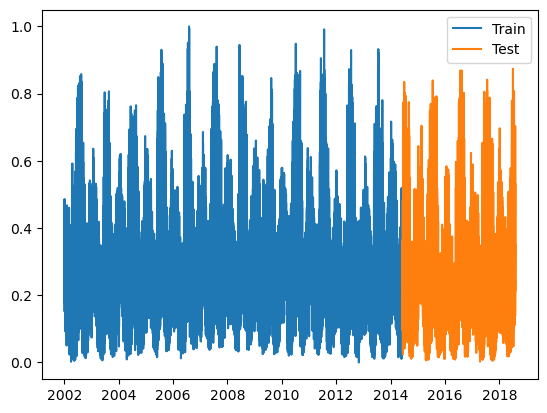

In [36]:


split_date = '12-Jun-2014'
train_ = data_forecasting_standart_lstm.loc[data_forecasting_standart_lstm.index <= split_date].copy()
test_ = data_forecasting_standart_lstm.loc[data_forecasting_standart_lstm.index > split_date].copy()
plt.plot(train_)
plt.plot(test_)

plt.legend(['Train', 'Test'])

In [37]:
lstm_model = Sequential()
lstm_model.add(Bidirectional(LSTM(128,activation="selu",return_sequences=True, input_shape=(X_train.shape[1],1))))
lstm_model.add(Dropout(0.2))
lstm_model.add(Bidirectional(LSTM(128,activation="selu",return_sequences=True)))
lstm_model.add(Dropout(0.2))
lstm_model.add(Bidirectional(LSTM(128,activation="selu",return_sequences=False)))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))



lstm_model.compile(optimizer="adam",loss="MSE")
lstm_model.summary

callback = EarlyStopping(
    monitor="loss",
    patience=2,
    restore_best_weights=True
)

lstm_model.fit(X_train, y_train, epochs=20, batch_size=1000,callbacks=[callback])

Epoch 1/20
110/110 [==============================] - 178s 2s/step - loss: 0.0962
Epoch 2/20
110/110 [==============================] - 162s 1s/step - loss: 0.0039
Epoch 3/20
110/110 [==============================] - 161s 1s/step - loss: 0.0028
Epoch 4/20
110/110 [==============================] - 160s 1s/step - loss: 0.0025
Epoch 5/20
110/110 [==============================] - 160s 1s/step - loss: 0.0018
Epoch 6/20
110/110 [==============================] - 160s 1s/step - loss: 0.0017
Epoch 7/20
110/110 [==============================] - 162s 1s/step - loss: 0.0014
Epoch 8/20
110/110 [==============================] - 162s 1s/step - loss: 0.0013
Epoch 9/20
110/110 [==============================] - 161s 1s/step - loss: 0.0012
Epoch 10/20
110/110 [==============================] - 160s 1s/step - loss: 0.0011
Epoch 11/20
110/110 [==============================] - 160s 1s/step - loss: 0.0012
Epoch 12/20
110/110 [==============================] - 160s 1s/step - loss: 9.9841e-04
Epoch 13/

1105/1105 [==============================] - 48s 42ms/step
R^2 Score of LSTM model =  0.9781590736722247


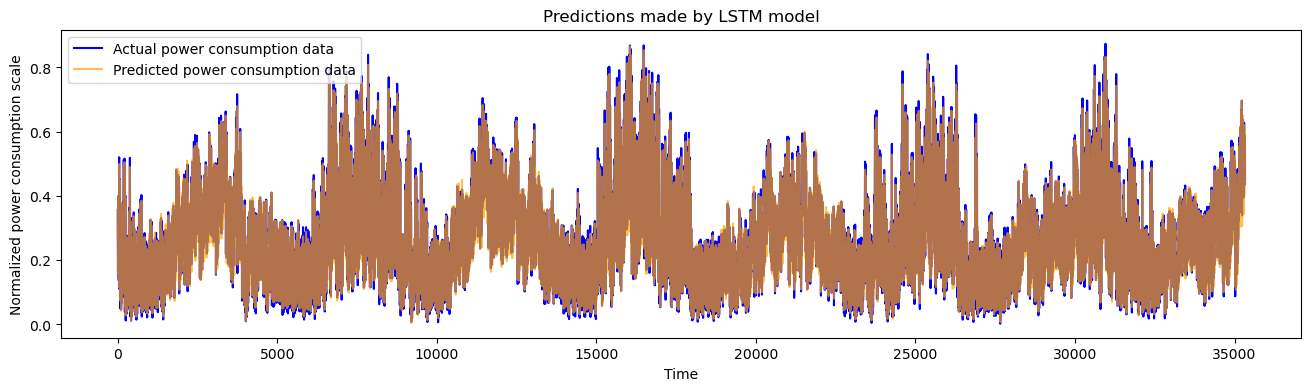

In [38]:
lstm_predictions = lstm_model.predict(X_test)

lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()
plot_predictions(y_test, lstm_predictions, "Predictions made by LSTM model")

In [39]:
from keras.models import load_model
lstm_model.save('lstm_standart.h5')

2. Making train/test dataset with "stoke-prediction approach".
This approach creates new dataframe, that consist target data and values. As target data uses target value from each day and values columns contain target data, but 1,2,3 day before. Also, using dayly data, not hourly as before.

In [40]:
data_forecasting_lstm

,Datetime,PJME_MW
0,2002-12-31 01:00:00,0.171349
1,2002-12-31 02:00:00,0.139824
2,2002-12-31 03:00:00,0.126453
3,2002-12-31 04:00:00,0.122229
4,2002-12-31 05:00:00,0.133126
...,...,...
145361,2018-01-01 20:00:00,0.586386
145362,2018-01-01 21:00:00,0.573949
145363,2018-01-01 22:00:00,0.542470
145364,2018-01-01 23:00:00,0.490246


In [41]:
df2=data_forecasting_lstm.copy()
df2['Datetime'] = pd.to_datetime(df2['Datetime']).dt.normalize()

data1 = df2[["Datetime", "PJME_MW"]]
data2 = data1.groupby(by=["Datetime"], as_index=False)["PJME_MW"].mean()
data2

,Datetime,PJME_MW
0,2002-01-01,0.278288
1,2002-01-02,0.352512
2,2002-01-03,0.358353
3,2002-01-04,0.339769
4,2002-01-05,0.262522
...,...,...
6054,2018-07-30,0.322080
6055,2018-07-31,0.358988
6056,2018-08-01,0.468469
6057,2018-08-02,0.476923


In [42]:
data2.index = data2.pop('Datetime')
data2

,PJME_MW
Datetime,
2002-01-01,0.278288
2002-01-02,0.352512
2002-01-03,0.358353
2002-01-04,0.339769
2002-01-05,0.262522
...,...
2018-07-30,0.322080
2018-07-31,0.358988
2018-08-01,0.468469


In [43]:
import datetime
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n):
  # first_date = str_to_datetime(first_date_str)
  # last_date  = str_to_datetime(last_date_str)
  # df['dates'] = pd.to_datetime(df['dates'], format='%Y%m%d')
  first_date =  pd.to_datetime(first_date_str)
  last_date  =  pd.to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['PJME_MW'].to_numpy()
    x, y = values[:-1], values[-1]
#
    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df


windowed_df = df_to_windowed_df(data2, '2002-01-05', '2018-08-03', 3)
windowed_df.head()

,Target Date,Target-3,Target-2,Target-1,Target
0,2002-01-05,0.352512,0.358353,0.339769,0.262522
1,2002-01-06,0.358353,0.339769,0.262522,0.260619
2,2002-01-07,0.339769,0.262522,0.260619,0.330864
3,2002-01-08,0.262522,0.260619,0.330864,0.354877
4,2002-01-09,0.260619,0.330864,0.354877,0.341186


In [44]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape



((6055,), (6055, 3, 1), (6055,))

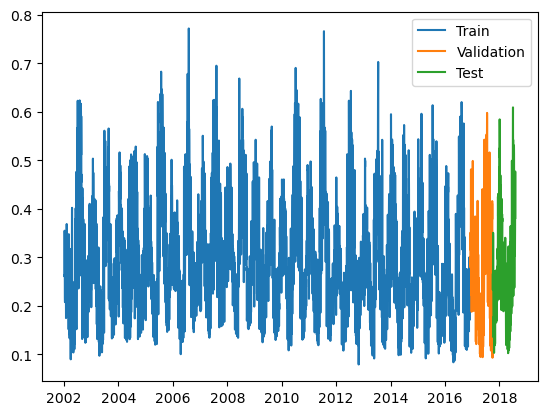

In [45]:
q_80 = int(len(dates) * .90)
q_90 = int(len(dates) * .95)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [46]:

lstm_model1 = Sequential()
lstm_model1.add(Bidirectional(LSTM(128,activation="selu",return_sequences=True, input_shape=(3,1))))
lstm_model1.add(Dropout(0.2))
lstm_model1.add(Bidirectional(LSTM(128,activation="selu",return_sequences=True)))
lstm_model1.add(Dropout(0.2))
lstm_model1.add(Bidirectional(LSTM(128,activation="selu",return_sequences=False)))
lstm_model1.add(Dropout(0.2))
lstm_model1.add(Dense(1))

lstm_model1.compile(loss='mse', optimizer='adam')

callback = EarlyStopping(
    monitor="loss",
    patience=2,
    restore_best_weights=True
)

lstm_model1.fit(X_train, y_train, epochs=100,validation_data=(X_val, y_val), batch_size=16,callbacks=[callback])

Epoch 1/100
341/341 [==============================] - 18s 26ms/step - loss: 0.0055 - val_loss: 0.0037
Epoch 2/100
341/341 [==============================] - 8s 23ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 3/100
341/341 [==============================] - 8s 24ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 4/100
341/341 [==============================] - 8s 24ms/step - loss: 0.0031 - val_loss: 0.0035
Epoch 5/100
341/341 [==============================] - 8s 23ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 6/100
341/341 [==============================] - 8s 23ms/step - loss: 0.0030 - val_loss: 0.0037
Epoch 7/100
341/341 [==============================] - 8s 23ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 8/100
341/341 [==============================] - 8s 24ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 9/100
341/341 [==============================] - 8s 23ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 10/100
341/341 [==============================] - 8s 23ms/step - loss: 0.00

10/10 [==============================] - 0s 9ms/step
train: 0.7857022869888313
test: 0.7508877197380049
val: 0.7211619304289635


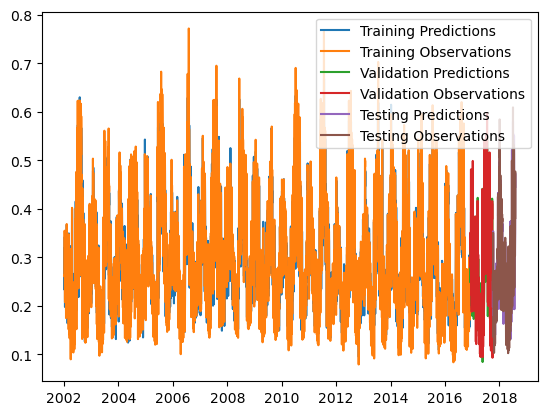

In [47]:
train_predictions = lstm_model1.predict(X_train).flatten()
val_predictions = lstm_model1.predict(X_val).flatten()
test_predictions = lstm_model1.predict(X_test).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])
print("train:",r2_score(y_train, train_predictions))
print("test:",r2_score(y_test, test_predictions))
print("val:",r2_score(y_val, val_predictions))

# Prophet model

In [48]:
data_prophet=data_forecasting_lstm.copy()
data_prophet=data_prophet.set_index("Datetime")
data_prophet.index=pd.to_datetime(data_prophet.index)
data_prophet

,PJME_MW
Datetime,
2002-12-31 01:00:00,0.171349
2002-12-31 02:00:00,0.139824
2002-12-31 03:00:00,0.126453
2002-12-31 04:00:00,0.122229
2002-12-31 05:00:00,0.133126
...,...
2018-01-01 20:00:00,0.586386
2018-01-01 21:00:00,0.573949
2018-01-01 22:00:00,0.542470


In [49]:
split_date = '1-Jan-2016'
train = data_prophet.loc[data_prophet.index <= split_date].copy()
test = data_prophet.loc[data_prophet.index > split_date].copy()


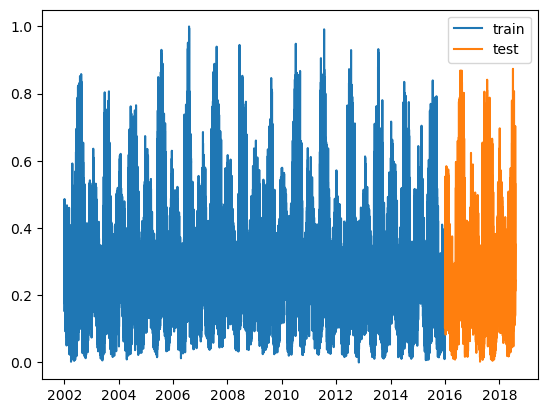

In [50]:
plt.plot(train)
plt.plot(test)
plt.legend(["train","test"])

In [51]:
train_prophet = train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})
test_prophet = test.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})
train_prophet

,ds,y
0,2002-12-31 01:00:00,0.171349
1,2002-12-31 02:00:00,0.139824
2,2002-12-31 03:00:00,0.126453
3,2002-12-31 04:00:00,0.122229
4,2002-12-31 05:00:00,0.133126
...,...,...
122666,2015-01-01 20:00:00,0.365823
122667,2015-01-01 21:00:00,0.353456
122668,2015-01-01 22:00:00,0.328371
122669,2015-01-01 23:00:00,0.287138


In [52]:
from prophet import Prophet

In [53]:
model = Prophet()
model.fit(train_prophet)

19:53:41 - cmdstanpy - INFO - Chain [1] start processing
19:55:29 - cmdstanpy - INFO - Chain [1] done processing


In [54]:
test_predict = model.predict(test_prophet)


In [55]:
test_predict

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-01-01 01:00:00,0.281372,0.094083,0.314284,0.281372,0.281372,-0.077021,-0.077021,-0.077021,-0.102890,...,0.021546,0.021546,0.021546,0.004323,0.004323,0.004323,0.0,0.0,0.0,0.204351
1,2016-01-01 02:00:00,0.281371,0.064661,0.282289,0.281371,0.281371,-0.112042,-0.112042,-0.112042,-0.137638,...,0.021216,0.021216,0.021216,0.004380,0.004380,0.004380,0.0,0.0,0.0,0.169329
2,2016-01-01 03:00:00,0.281371,0.043154,0.255242,0.281371,0.281371,-0.132399,-0.132399,-0.132399,-0.157690,...,0.020854,0.020854,0.020854,0.004437,0.004437,0.004437,0.0,0.0,0.0,0.148972
3,2016-01-01 04:00:00,0.281370,0.036582,0.253072,0.281370,0.281370,-0.135778,-0.135778,-0.135778,-0.160725,...,0.020452,0.020452,0.020452,0.004496,0.004496,0.004496,0.0,0.0,0.0,0.145592
4,2016-01-01 05:00:00,0.281369,0.052904,0.270442,0.281369,0.281369,-0.120178,-0.120178,-0.120178,-0.144734,...,0.020001,0.020001,0.020001,0.004555,0.004555,0.004555,0.0,0.0,0.0,0.161191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22674,2018-08-02 20:00:00,0.264369,0.179294,0.901643,-0.065872,0.618394,0.262252,0.262252,0.262252,0.103775,...,0.022948,0.022948,0.022948,0.135529,0.135529,0.135529,0.0,0.0,0.0,0.526621
22675,2018-08-02 21:00:00,0.264369,0.153506,0.868469,-0.065893,0.618436,0.244072,0.244072,0.244072,0.085984,...,0.022681,0.022681,0.022681,0.135407,0.135407,0.135407,0.0,0.0,0.0,0.508440
22676,2018-08-02 22:00:00,0.264368,0.135742,0.843130,-0.065915,0.618478,0.206068,0.206068,0.206068,0.048370,...,0.022413,0.022413,0.022413,0.135285,0.135285,0.135285,0.0,0.0,0.0,0.470436
22677,2018-08-02 23:00:00,0.264367,0.080752,0.774192,-0.065936,0.618520,0.154760,0.154760,0.154760,-0.002541,...,0.022138,0.022138,0.022138,0.135163,0.135163,0.135163,0.0,0.0,0.0,0.419127


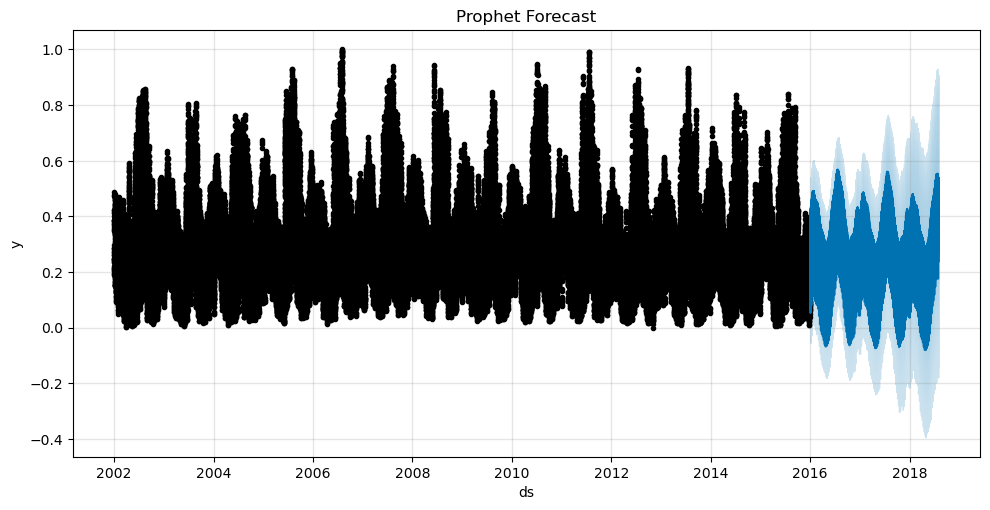

In [56]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(test_predict, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

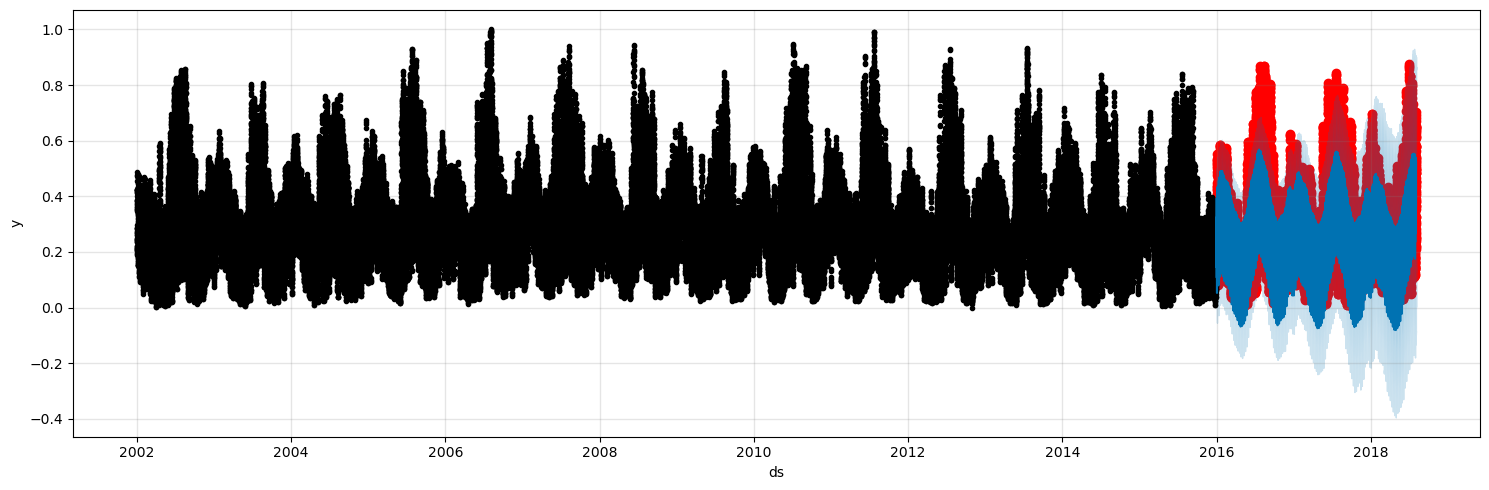

In [57]:

f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(test.index, test['PJME_MW'], color='r')
fig = model.plot(test_predict, ax=ax)

In [58]:
mean_squared_error(test['PJME_MW'],test_predict['yhat'])

0.021664781404563623

In [59]:
future = model.make_future_dataframe(periods=365*24*2, freq='h', include_history=False)
future

,ds
0,2016-01-01 01:00:00
1,2016-01-01 02:00:00
2,2016-01-01 03:00:00
3,2016-01-01 04:00:00
4,2016-01-01 05:00:00
...,...
17515,2017-12-30 20:00:00
17516,2017-12-30 21:00:00
17517,2017-12-30 22:00:00
17518,2017-12-30 23:00:00


In [60]:
forecast = model.predict(future)

In [61]:
forecast[['ds','yhat']].describe()

,yhat
count,17520.000000
mean,0.274755
std,0.124317
min,-0.073974
25%,0.190391
50%,0.281253
75%,0.365815
max,0.568169


In [62]:
future_pred=forecast[['ds','yhat']]
future_pred=future_pred.set_index("ds")
future_pred.index=pd.to_datetime(future_pred.index)

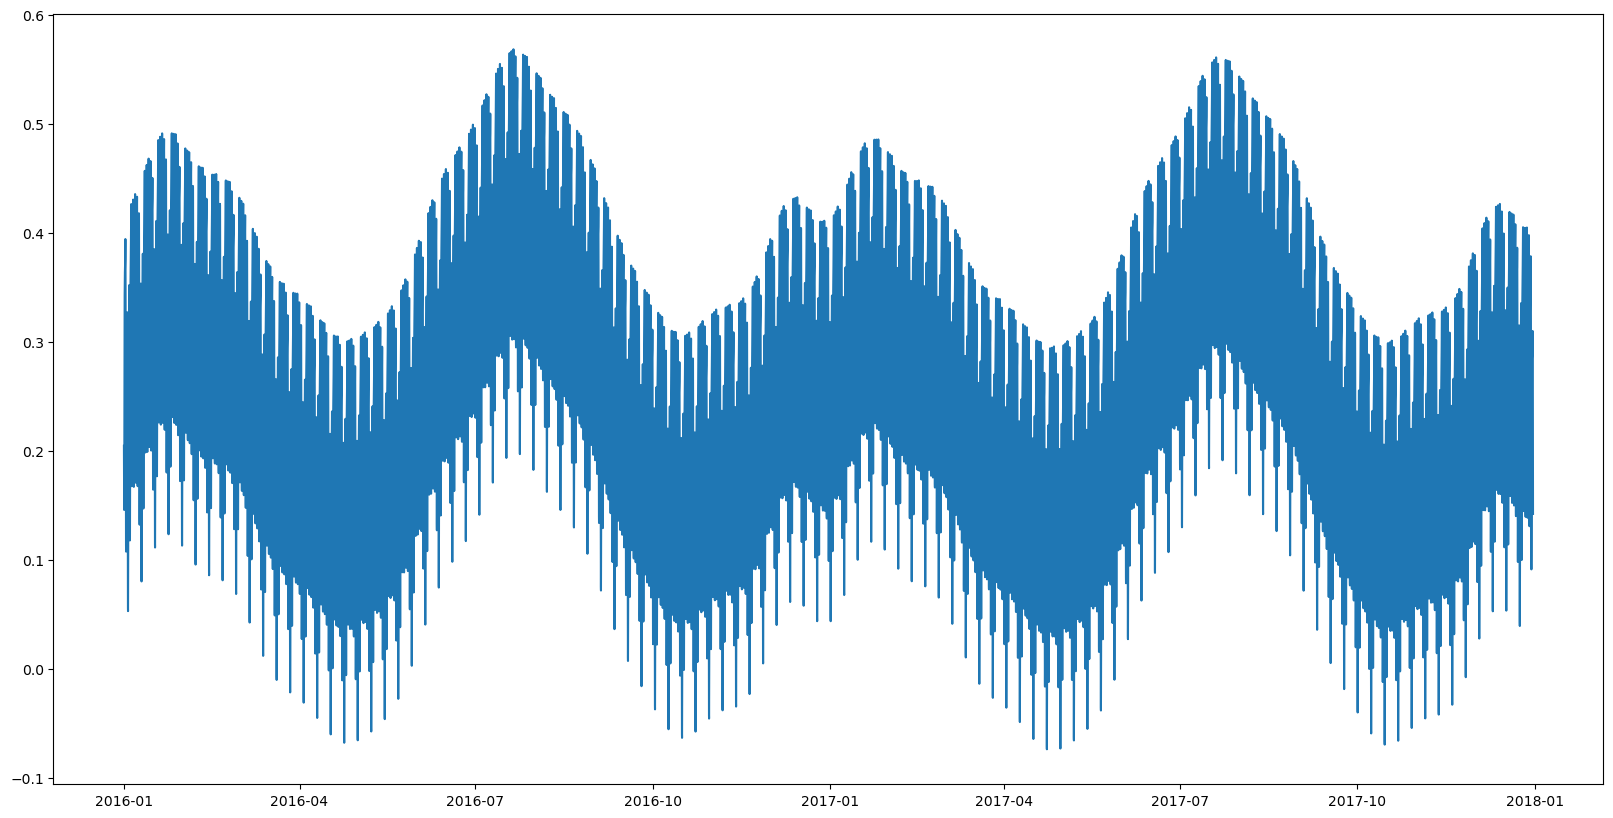

In [63]:
plt.figure(figsize=(20,10))
plt.plot(future_pred)

# Conclusion
The most accurate model is Bidirectional LSTM with "standart" test/train preparation

# References
* [Forecasting with the FB Prophet Model](https://www.youtube.com/watch?v=j0eioK5edqg&t=425s)
* [Hourly energy consumption time series RNN, LSTM](https://www.kaggle.com/code/msripooja/hourly-energy-consumption-time-series-rnn-lstm#3.-Prepare-data-for-training-the-RNN-models)
* [Time Series Forecasting with XGBoost - Advanced Methods](https://www.youtube.com/watch?v=z3ZnOW-S550&list=RDCMUCxladMszXan-jfgzyeIMyvw&index=3)
